In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
%matplotlib inline
import datetime
import keras
from keras import Sequential
from keras.layers import LSTM, Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
import time

import tensorflow as tf

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from matplotlib import rc

In [3]:
font = {'family' : 'sans-serif',
        'size'   : 24}

rc('font', **font)

In [4]:
def periods_w_demand_new(df, sales):
    nuls = []
    not_nuls = []
    nul_count = 0
    notnul_count = 0
    for i in df[sales]:
        nuls.append(nul_count)
        not_nuls.append(notnul_count)
        if i == 0:
            nul_count += 1
            notnul_count = 0
        else:
            nul_count =0
            notnul_count +=1
    return pd.DataFrame([nuls, not_nuls], index=['nuls', 'notnuls']).T

In [5]:
class TimeSeriesModelling():
    from sklearn import metrics
    def __init__(self, df):
        self.df = df
        
    def set_date(self, date_index):
        self.df[date_index] = pd.to_datetime(self.df[date_index])
        self.df[date_index] = [x.date() for x in self.df[date_index]]
        self.df.set_index(date_index, inplace=True)

        
    def scale_data(self, df, scaler, values_index):
        self.scaled = scaler.transform(df[values_index].values.reshape(-1,1))
        return self.scaled
    
    
    def difference_data(self, scaled):
        self.scaled = pd.DataFrame(scaled, columns=['sales'])
        self.diff = self.scaled.diff()
        self.diff = self.diff.dropna()
        return self.diff
        
    def de_difference(self, diff_n):
        origi = pd.concat([pd.DataFrame([0], columns=['sales']),
                           pd.DataFrame(ts.scaled, columns=['sales']).iloc[2:,:]])
        origi.reset_index(inplace=True, drop=True)
        value = diff_n + origi
        return value.dropna()

    
    def preprocessing(self, differenced, lagshift=1):
        self.diff = differenced
        for s in range(1,lagshift+1):
            self.diff['shift_{}'.format(s)] = differenced['sales'].shift(s)
        self.diff.dropna(inplace=True)
        array_fit = (self.diff.values)
        self.X, self.y = array_fit[:, 0:-1], array_fit[:, -1]
        self.X = self.X.reshape(self.X.shape[0], 1, self.X.shape[1])
        return self.X, self.y    


    def add_additional_feat(self, df, list_feat, scaler):
        full_extra = df.reset_index(drop=True)
        full_extra = full_extra.loc[(len(df) - len(self.X)):, list_feat]
        full_extra.reset_index(inplace=True, drop=True)
        #full_extra = scaler.transform(full_extra)
        self.X = pd.DataFrame(ts.X.reshape(ts.X.shape[0], ts.X.shape[2]),
                              columns=['sales'.format(x) for x in range(ts.X.shape[2])]).join(pd.DataFrame(full_extra))
        self.X = self.X.values.reshape(self.X.shape[0], 1, self.X.shape[1])
        return self.X

    
    def train_test_split(self, X, y, train_size=0.75):
        self.X_train = X[:round((len(X)*train_size))]
        self.X_test = X[round((len(X)*train_size)):]
        self.y_train = y[:round((len(y)*train_size))]
        self.y_test = y[round((len(y)*train_size)):]
        return self.X_train, self.X_test, self.y_train, self.y_test

    
    def plot_timeseries(self, values_index, train=False, test=False):
        self.df[values_index].plot(kind='line', figsize=(15,5))  
        if train == True:
            f, ax = plt.subplots(figsize=(15,5))
            plt.plot(self.X_train[:,:,0].reshape(-1,1))
            plt.show()
        if test == True:
            f, ax = plt.subplots(figsize=(15,5))
            plt.plot(self.X_test[:,:,0].reshape(-1,1))
            plt.show()

In [6]:
class BaselineModel:
    def __init__(self, X_train, X_test):
        self.X_train = X_train
        self.X_test = X_test
        
    def create_baseline_model(self, plot=True):
        history = [x for x in self.X_train[:,:,0].reshape(-1,1)]
        predictions = list()
        for i in range(len(self.X_test[:,:,0].reshape(-1,1))):
            # make prediction
            predictions.append(history[-1])
            # observation
            history.append(self.X_test[:,:,0].reshape(-1,1)[i])
        # report performance
        rmse = np.sqrt(metrics.mean_squared_error(self.X_test[:,:,0].reshape(-1,1), predictions))
        mse = metrics.mean_squared_error(self.X_test[:,:,0].reshape(-1,1), predictions)
        print('RMSE: %.3f' % rmse)
        print('MSE: %.3f' % mse)
        self.baseline = predictions
        # line plot of observed vs predicted
        if plot == True:
            plt.subplots(figsize=(18,8))
            plt.plot(self.X_test[:,:,0].reshape(-1,1))
            plt.plot(predictions)
            plt.show()

In [7]:
class ModelEvaluation:
    def __init__(self, model):
        self.model = model
        
    def evaluate_model(self, X_train, X_test, y_train, y_test):
        self.mse_test = self.model.evaluate(X_test, y_test, batch_size=1)
        self.mse_train = self.model.evaluate(X_train, y_train, batch_size=1)
        print('The model has a test MSE of {} and a train MSE of {}.'.format(self.mse_test, self.mse_train))
        
        self.y_pred = self.model.predict(X_test, batch_size=1)
        self.y_hat = self.model.predict(X_train, batch_size=1)
        
        self.r2_test = metrics.r2_score(y_test, self.y_pred)
        self.r2_train = metrics.r2_score(y_train, self.y_hat)
        
        print('The model has a test R2 of {} and a train R2 of {}.'.format(self.r2_test, self.r2_train))
        
    def plot_evaluation(self, y_train, y_test):
        plt.subplots(figsize=(15,8))
        plt.plot(y_train, c='darkorange')
        plt.plot(self.y_hat, c='teal')
        plt.title('Train dataset and predictions')
        plt.show()
        plt.subplots(figsize=(15,8))
        plt.plot(y_test, c='tomato')
        plt.plot(self.y_pred, c='indigo')
        plt.title('Test dataset and predictions')
        plt.show()
            
    

In [8]:
def parameterize_output(x, threshold=0.5):
    '''This small function just takes in a number predicted by the model,
    and makes it discrete.
    The function will round up or down with an equal probability, unless specified. 
    The aim would be to use the number of 0's in the dataset as a guideline for
    rounding up or down. The proportion of 0's can be used to on a scale from 0 to 0.5
    where 0 is all 0's and 0.5 is no zeros.
    
    '''
    import math
    chance = np.random.uniform()
    if chance <= threshold:
        return np.round(x)
    else:
        return np.fix(x)

In [9]:
def is_sales(sales):
    return pd.DataFrame([0 if x != 0 else 1 for x in sales], columns = ['is_sales'])

In [10]:
df = pd.read_csv('../data/snapshot_full_df.csv')
df_train = df.copy()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
df_train.sort_values(['store_key', 'sku_key', 'tran_date'], inplace=True)

In [12]:
df_train.shape

(5087491, 13)

In [13]:
df_train.head()

,Unnamed: 0,store_key,sku_key,tran_date,sales,selling_price,avg_discount,store_region,store_grading,sku_department,sku_subdepartment,sku_category,sku_subcategory
3742481,3742481,3,521,2016-03-26,1,159.9,0.0,KWA,A,BH,2,38,17H
3742161,3742161,3,521,2016-03-27,0,159.9,0.0,KWA,A,BH,2,38,17H
3742326,3742326,3,521,2016-03-28,0,159.9,0.0,KWA,A,BH,2,38,17H
3741937,3741937,3,521,2016-03-29,0,159.9,0.0,KWA,A,BH,2,38,17H
3742259,3742259,3,521,2016-03-30,1,159.9,0.0,KWA,A,BH,2,38,17H


In [14]:
df_train = df_train.iloc[:500000]

In [15]:
df_train.drop('Unnamed: 0', axis=1, inplace=True)

In [16]:
def preprocess_df(df):
    df.loc[:,'weekday'] = df.loc[:,'tran_date'].dt.weekday_name
    df.loc[:,'day'] = df.loc[:,'tran_date'].dt.day
    df.loc[:,'month'] = df.loc[:,'tran_date'].dt.month
    df.loc[:,'week'] = df.loc[:,'tran_date'].dt.week
    cat = ['store_region', 'store_grading', 'sku_department',
           'sku_subdepartment', 'sku_category', 'sku_subcategory',
           'time_of_week', 'monthend', 'month', 'week', 'weekday']
    df.loc[:,'time_of_week'] = ['Weekend' if x in ['Saturday', 'Sunday', 'Friday'] else 'Weekday' for x in df.loc[:,'weekday']]
    df.loc[:,'monthend'] = ['Monthend' if x in [25, 26, 27, 28, 29, 30,
                                            31, 1, 2, 3, 4, 5] else 'Not-Monthend' for x in df.loc[:,'day']]
    df.drop(['day'], axis=1, inplace=True)
    for i in cat:
        df = df.join(pd.get_dummies(df[i], prefix=i))

    df.drop(cat, axis=1, inplace=True)
    df = df.reset_index(drop=True)
    for i in range(2,12):
        df.loc[:,'agg{}'.format(i)] = df.loc[:,'sales'].rolling(i).mean()
    for i in range(10,11):
        df.loc[:,'max{}'.format(i)] = df.loc[:,'sales'].rolling(i).max()
    for i in range(10,11):
        df.loc[:,'min{}'.format(i)] = df.loc[:,'sales'].rolling(i).min()
    df.dropna(inplace=True)
    
    extra = periods_w_demand_new(df, 'sales')
    sales = is_sales(df['sales'])
    df = df.reset_index(drop=True).join(extra).join(sales)
    
    return df

In [17]:
df_train['tran_date'] = pd.to_datetime(df_train['tran_date'])

In [18]:
start = time.time()
full_sales = preprocess_df(df_train)
end = time.time()


In [19]:
print('It took a full {} minutes'.format((end-start)/60))

It took a full 0.6912418007850647 minutes


In [20]:
full_sales.head(1)

,store_key,sku_key,tran_date,sales,selling_price,avg_discount,store_region_GTN,store_region_KWA,store_grading_A,sku_department_AM,...,agg7,agg8,agg9,agg10,agg11,max10,min10,nuls,notnuls,is_sales
0,3,521,2016-04-05,0,159.9,0.0,0,1,1,0,...,0.285714,0.25,0.222222,0.2,0.272727,1.0,0.0,0,0,1


In [21]:
cat = full_sales.columns[4:]
cat

Index(['selling_price', 'avg_discount', 'store_region_GTN', 'store_region_KWA',
       'store_grading_A', 'sku_department_AM', 'sku_department_BC',
       'sku_department_BH', 'sku_department_BY', 'sku_department_CF',
       ...
       'agg7', 'agg8', 'agg9', 'agg10', 'agg11', 'max10', 'min10', 'nuls',
       'notnuls', 'is_sales'],
      dtype='object', length=468)

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = MinMaxScaler()
scaler.fit(full_sales['sales'].values.reshape(-1,1))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [24]:
cat2 = ['selling_price', 'avg_discount', 'max10', 'min10',
        'agg2', 'agg3', 'agg4', 'agg5', 'agg6', 'agg7',
        'agg8', 'agg9', 'agg10', 'agg11', 'nuls', 'notnuls', 'is_sales']

In [25]:
scale_add = MinMaxScaler()
scale_add.fit(full_sales[cat2])
full_sales[cat2] = scale_add.transform(full_sales[cat2])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [26]:
subset_df = full_sales#[full_sales['sku_key']==48676]

In [27]:
ts = TimeSeriesModelling(subset_df)
#ts.set_date('tran_date')
df = ts.scale_data(subset_df, scaler=scaler, values_index='sales')
df = pd.DataFrame(df, columns=['sales'])

X, y = ts.preprocessing(df, lagshift=1)
X = ts.add_additional_feat(subset_df, cat, scale_add)
X = X.reshape(X.shape[0], X.shape[2])
X_train, X_test, y_train, y_test = ts.train_test_split(X, y, 0.8)


In [28]:
X.shape

(499989, 473)

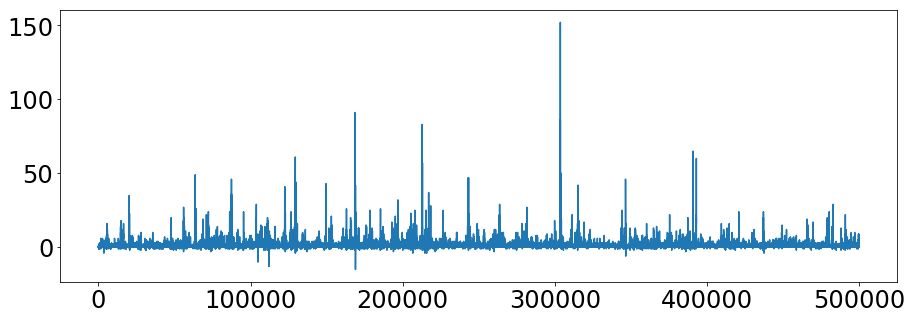

In [29]:
ts.plot_timeseries('sales')

## Model all features:

In [30]:
from keras.optimizers import Adam

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [32]:
K.clear_session()
adam = Adam(lr=0.0001)
model = Sequential()
model.add(Dense(128, input_shape=(473,), activation='tanh'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               60672     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 61,713
Trainable params: 61,713
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(X_train, y_train, batch_size=128, epochs=200, callbacks=[early_stop], validation_split=0.1)

Train on 359991 samples, validate on 40000 samples
Epoch 1/200
359991/359991 [==============================] - 12s 33us/step - loss: 0.0011 - val_loss: 1.1201e-04
Epoch 2/200
359991/359991 [==============================] - 11s 31us/step - loss: 3.0836e-05 - val_loss: 8.0532e-05
Epoch 3/200
359991/359991 [==============================] - 11s 31us/step - loss: 2.4104e-05 - val_loss: 6.5150e-05
Epoch 4/200
359991/359991 [==============================] - 11s 31us/step - loss: 1.9800e-05 - val_loss: 4.6979e-05
Epoch 5/200
359991/359991 [==============================] - 11s 31us/step - loss: 1.7037e-05 - val_loss: 5.4153e-05
Epoch 6/200
359991/359991 [==============================] - 11s 31us/step - loss: 1.4969e-05 - val_loss: 4.0833e-05
Epoch 7/200
359991/359991 [==============================] - 11s 31us/step - loss: 1.3180e-05 - val_loss: 4.7598e-05
Epoch 8/200
359991/359991 [==============================] - 11s 31us/step - loss: 1.1732e-05 - val_loss: 4.2028e-05
Epoch 9/200
35999

In [69]:
me = ModelEvaluation(model)

In [177]:
me.evaluate_model(X_train, X_test, y_train, y_test)

489/489 [==============================] - 0s 783us/step
The model has a test MSE of 0.007985563148490674 and a train MSE of 0.00247736834549476.
The model has a test R2 of -2.6336201425635 and a train R2 of 0.5515193821039935.


AttributeError: 'ModelEvaluation' object has no attribute 'y_hat'

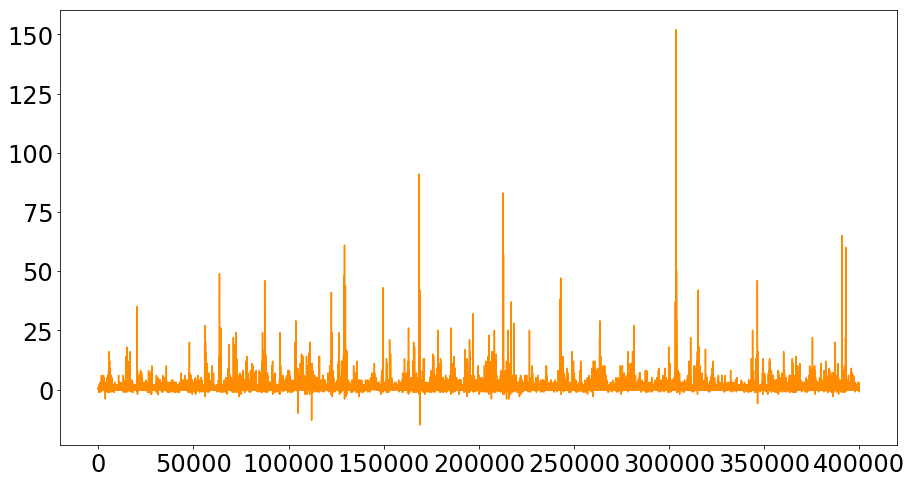

In [70]:
me.plot_evaluation(y_train, y_test)

### Evaluate only one:

In [294]:
full_sales[['sku_key', 'store_key', 'sales']].groupby(['sku_key', 'store_key']).sum().sort_values('sales', ascending=False)

,,sales
sku_key,store_key,
47593,4,3527
24899,4,2860
44662,3,1798
35800,3,1664
50124,3,1449
49067,3,1434
50986,3,1184
38720,3,1045
38676,4,1024


In [35]:
subset_df = full_sales[(full_sales['sku_key']==47593)&(full_sales['store_key'] == 4)]

In [36]:
subset_df.head()

,store_key,sku_key,tran_date,sales,selling_price,avg_discount,store_region_GTN,store_region_KWA,store_grading_A,sku_department_AM,...,agg7,agg8,agg9,agg10,agg11,max10,min10,nuls,notnuls,is_sales
303261,4,47593,2016-03-01,1,0.003976,0.230769,1,0,1,0,...,0.021401,0.020370,0.018676,0.017323,0.015988,0.006579,0.405405,0.080745,0.000000,0.0
303262,4,47593,2016-03-02,0,0.003976,0.230769,1,0,1,0,...,0.021401,0.020370,0.018676,0.017323,0.015988,0.006579,0.405405,0.000000,0.020833,1.0
303263,4,47593,2016-03-03,0,0.003976,0.230769,1,0,1,0,...,0.021401,0.020370,0.018676,0.017323,0.015988,0.006579,0.405405,0.002070,0.000000,1.0
303264,4,47593,2016-03-04,2,0.003976,0.230769,1,0,1,0,...,0.025292,0.024074,0.022071,0.020472,0.018895,0.013158,0.405405,0.004141,0.000000,0.0
303265,4,47593,2016-03-05,1,0.003976,0.230769,1,0,1,0,...,0.027237,0.025926,0.023769,0.022047,0.020349,0.013158,0.405405,0.000000,0.020833,0.0


In [37]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701 entries, 303261 to 303961
Columns: 472 entries, store_key to is_sales
dtypes: datetime64[ns](1), float64(17), int64(3), uint8(451)
memory usage: 429.2 KB


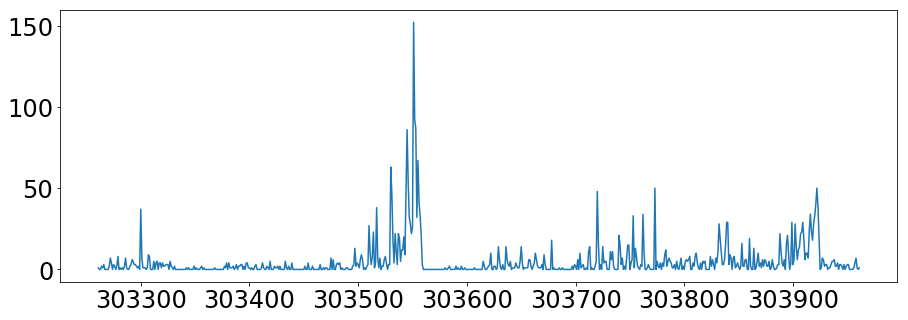

In [38]:
ts = TimeSeriesModelling(subset_df)
df = ts.scale_data(subset_df, scaler=scaler, values_index='sales')
df = pd.DataFrame(df, columns=['sales'])
X, y = ts.preprocessing(df, lagshift=1)
X = ts.add_additional_feat(subset_df, cat, scale_add)
X = X.reshape(X.shape[0], X.shape[2])
X_train, X_test, y_train, y_test = ts.train_test_split(X, y, 0.8)
ts.plot_timeseries('sales')


In [39]:
X_train.shape

(560, 473)

In [40]:
me = ModelEvaluation(model)

In [41]:
me.evaluate_model(X_train, X_test, y_train, y_test)

560/560 [==============================] - 0s 742us/step
The model has a test MSE of 4.056970136302621e-05 and a train MSE of 5.964240181532043e-05.
The model has a test R2 of 0.9883554964109451 and a train R2 of 0.9883433574967871.


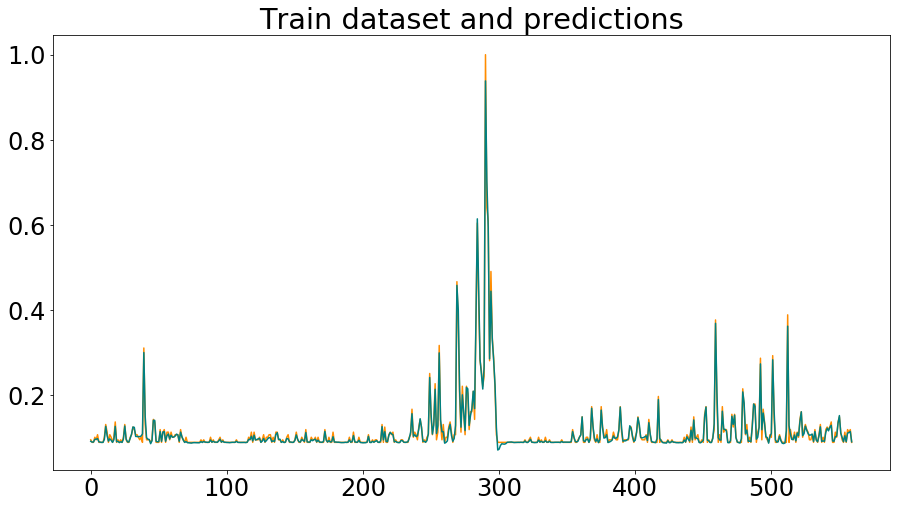

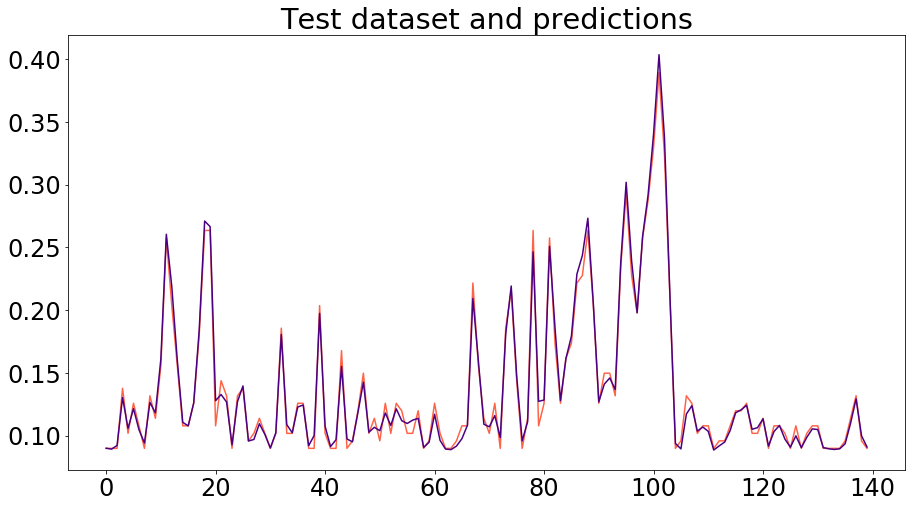

In [42]:
me.plot_evaluation(y_train, y_test)

In [43]:
model.save('all_features_ann.h5')  # creates a HDF5 file 'my_model.h5'

In [26]:
from keras.models import load_model
model = load_model('all_features_ann.h5')

# Blind predict

In [44]:
ts = TimeSeriesModelling(subset_df)
ts.set_date('tran_date')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
subset_df.shape

(701, 471)

Split into training

In [116]:
train = subset_df.iloc[:-90]
test = subset_df.iloc[-90:]

In [117]:
train.tail(1)

,store_key,sku_key,sales,selling_price,avg_discount,store_region_GTN,store_region_KWA,store_grading_A,sku_department_AM,sku_department_BC,...,agg7,agg8,agg9,agg10,agg11,max10,min10,nuls,notnuls,is_sales
tran_date,,,,,,,,,,,,,,,,,,,,,
2017-11-01,4,47593,1,0.003476,0.230769,1,0,1,0,0,...,0.064202,0.085185,0.078098,0.072441,0.069767,0.085526,0.405405,0.0,0.104167,0.0


In [118]:
test.head(1)

,store_key,sku_key,sales,selling_price,avg_discount,store_region_GTN,store_region_KWA,store_grading_A,sku_department_AM,sku_department_BC,...,agg7,agg8,agg9,agg10,agg11,max10,min10,nuls,notnuls,is_sales
tran_date,,,,,,,,,,,,,,,,,,,,,
2017-11-02,4,47593,6,0.003476,0.230769,1,0,1,0,0,...,0.075875,0.072222,0.088285,0.08189,0.075581,0.085526,0.405405,0.0,0.125,0.0


In [119]:
float(scaler.inverse_transform(model.predict(X[-1,:].reshape(1,X.shape[-1]))))

31.836063385009766

In [120]:
# BLIND 90 Days
import datetime
predicted = []

zeros = ((train['sales'] == 0).sum() / len(train))
print('We have {} zeros'.format(zeros))
for i in range(90):
    df = ts.scale_data(train, scaler=scaler, values_index='sales')
    df = pd.DataFrame(df, columns=['sales'])
    X, y = ts.preprocessing(df, lagshift=1)
    X = ts.add_additional_feat(train, cat, scale_add)
    X = X.reshape(X.shape[0], X.shape[2])

    predict = model.predict(X[-1,:].reshape(1,X.shape[-1]))    
       
    changes = train.iloc[-1,:].copy()
    changes = pd.DataFrame(changes).T
    changes[cat2] = scale_add.inverse_transform(changes[cat2].values.reshape(1,-1))
    #This is where the add features go
    #Dates
    next_date = pd.to_datetime(train.index[-1] + datetime.timedelta(days=1))
    last_day = next_date.day
    last_week = next_date.week
    last_month = next_date.month
    last_year = next_date.year
    last_dayname = next_date.weekday_name
    
    if last_day in [25, 26, 27, 28, 29, 30, 31, 1, 2, 3, 4, 5]:
        changes.loc[:,'monthend_Not-Monthend'] = 0
        changes.loc[:,'monthend_Monthend'] = 1
    else:
        changes.loc[:,'monthend_Not-Monthend'] = 1
        changes.loc[:,'monthend_Monthend'] = 0
    
    if last_dayname in ['Saturday', 'Sunday', 'Friday']:
        changes.loc[:,'time_of_week_Weekday'] = 0
        changes.loc[:,'time_of_week_Weekend'] = 1
    else:
        changes.loc[:,'time_of_week_Weekday'] = 1
        changes.loc[:,'time_of_week_Weekend'] = 0

    for i in range(1, 53):
        changes['week_{}'.format(i)] = 0
        if i == last_week:
            changes['week_{}'.format(i)] = 1
            
    for i in range(1, 13):
        changes['month_{}'.format(i)] = 0
        if i == last_month:
            changes['month_{}'.format(i)] = 1
            
    for i in ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
              'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
              'weekday_Wednesday']:
        changes[i] = 0
        if i == 'weekday_{}'.format(last_dayname):
            changes.loc[:,i] = 1
    
    random_nr = np.random.uniform()
    
    if random_nr < zeros/10:
        changes.loc[:,'sales'] = 0
        predicted.append(0)
    elif random_nr < zeros/2:
        changes.loc[:,'sales'] = float(scaler.inverse_transform(predict).reshape(-1))/2
        predicted.append(float(scaler.inverse_transform(predict).reshape(-1))/2)
    else:
        changes.loc[:,'sales'] = float(scaler.inverse_transform(predict).reshape(-1))
        predicted.append(float(scaler.inverse_transform(predict).reshape(-1)))
    
    #changes = pd.DataFrame(changes).T
    changes.index = [next_date]
    train = pd.concat([train, changes])
    
    #Aggregates
    for i in range(2,12):
        train.loc[next_date,'agg{}'.format(i)] = train.iloc[-i:,2].rolling(i).mean()[-1]
    train.dropna(inplace=True)
    
    for i in range(10,11):
        train.loc[next_date,'max{}'.format(i)] = train.iloc[-i:,2].rolling(i).max()[-1]
    train.dropna(inplace=True)
    
    for i in range(10,11):
        train.loc[next_date,'min{}'.format(i)] = train.iloc[-i:,2].rolling(i).min()[-1]
    train.dropna(inplace=True)
    
    
    #Nuls
    notnuls = []
    
    nul_counter = 0
    nulidx = -2
    ntick = True
    while ntick == True:
        if np.fix(train.iloc[nulidx, 2]) == 0:
            nul_counter += 1
            nulidx -= 1
        else:
            ntick = False
            
    nnul_counter = 0
    nnulidx = -2
    tick = True
    while tick == True:
        if np.fix(train.iloc[nnulidx, 2]) != 0:
            nnul_counter += 1
            nnulidx -= 1
        else:
            tick = False
    
    is_sales = 0
    if round(train.loc[next_date, 'sales']) == 0:
        is_sales = 0
    else:
        is_sales = 1
    
    train.loc[next_date, 'nuls'] = nul_counter
    train.loc[next_date, 'notnuls'] = nnul_counter
    train.loc[next_date, 'is_sales'] = is_sales
    
    train.loc[next_date, cat2] = scale_add.transform(train.loc[next_date, cat2].values.reshape(1, -1)).reshape(-1)
    

We have 0.4206219312602291 zeros


In [121]:
train.reset_index(inplace=True)
train['index'] = pd.to_datetime(train['index'])
train.set_index('index', inplace=True)

test.reset_index(inplace=True)
test['tran_date'] = pd.to_datetime(test['tran_date'])
test.set_index('tran_date', inplace=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [122]:
train.columns[0:]

Index(['store_key', 'sku_key', 'sales', 'selling_price', 'avg_discount',
       'store_region_GTN', 'store_region_KWA', 'store_grading_A',
       'sku_department_AM', 'sku_department_BC',
       ...
       'agg7', 'agg8', 'agg9', 'agg10', 'agg11', 'max10', 'min10', 'nuls',
       'notnuls', 'is_sales'],
      dtype='object', length=471)

In [123]:
train.shape

(701, 471)

Looks like the problem lies in the scaling. The aggregates are scaled, but the sales not. Fix this and thebmdoel could fwords


In [124]:
train.tail()

,store_key,sku_key,sales,selling_price,avg_discount,store_region_GTN,store_region_KWA,store_grading_A,sku_department_AM,sku_department_BC,...,agg7,agg8,agg9,agg10,agg11,max10,min10,nuls,notnuls,is_sales
index,,,,,,,,,,,,,,,,,,,,,
2018-01-26,4.0,47593.0,-0.151071,0.003476,0.230769,1.0,0.0,1.0,0.0,0.0,...,0.016591,0.015378,0.013714,0.012378,0.011127,-0.000994,0.398362,0.062112,0.0,0.0
2018-01-27,4.0,47593.0,-0.084627,0.003476,0.230769,1.0,0.0,1.0,0.0,0.0,...,0.016848,0.015635,0.013955,0.012587,0.011302,-0.000557,0.398362,0.064182,0.0,0.0
2018-01-28,4.0,47593.0,-0.172846,0.003476,0.230769,1.0,0.0,1.0,0.0,0.0,...,0.016829,0.015717,0.014041,0.012672,0.011366,-0.000557,0.398362,0.066253,0.0,0.0
2018-01-29,4.0,47593.0,-0.143316,0.003476,0.230769,1.0,0.0,1.0,0.0,0.0,...,0.016957,0.015754,0.014166,0.012798,0.011487,-0.000557,0.398362,0.068323,0.0,0.0
2018-01-30,4.0,47593.0,-0.121850,0.003476,0.230769,1.0,0.0,1.0,0.0,0.0,...,0.017147,0.015914,0.014236,0.012948,0.011635,-0.000557,0.398362,0.070393,0.0,0.0


In [125]:
test.shape

(90, 471)

In [126]:
test.tail()

,store_key,sku_key,sales,selling_price,avg_discount,store_region_GTN,store_region_KWA,store_grading_A,sku_department_AM,sku_department_BC,...,agg7,agg8,agg9,agg10,agg11,max10,min10,nuls,notnuls,is_sales
tran_date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,4,47593,4,0.003476,0.230769,1,0,1,0,0,...,0.035019,0.038889,0.039049,0.036220,0.037791,0.026316,0.405405,0.00000,0.020833,0.0
2018-01-27,4,47593,7,0.003476,0.230769,1,0,1,0,0,...,0.042802,0.046296,0.047538,0.047244,0.043605,0.046053,0.405405,0.00000,0.041667,0.0
2018-01-28,4,47593,1,0.003476,0.230769,1,0,1,0,0,...,0.044747,0.042593,0.044143,0.045669,0.045058,0.046053,0.405405,0.00000,0.062500,0.0
2018-01-29,4,47593,0,0.003976,0.230769,1,0,1,0,0,...,0.044747,0.042593,0.039049,0.040945,0.042151,0.046053,0.405405,0.00000,0.083333,1.0
2018-01-30,4,47593,1,0.003476,0.230769,1,0,1,0,0,...,0.046693,0.044444,0.040747,0.037795,0.039244,0.046053,0.405405,0.00207,0.000000,0.0


In [127]:
train['sales'] = train['sales'].astype('float')

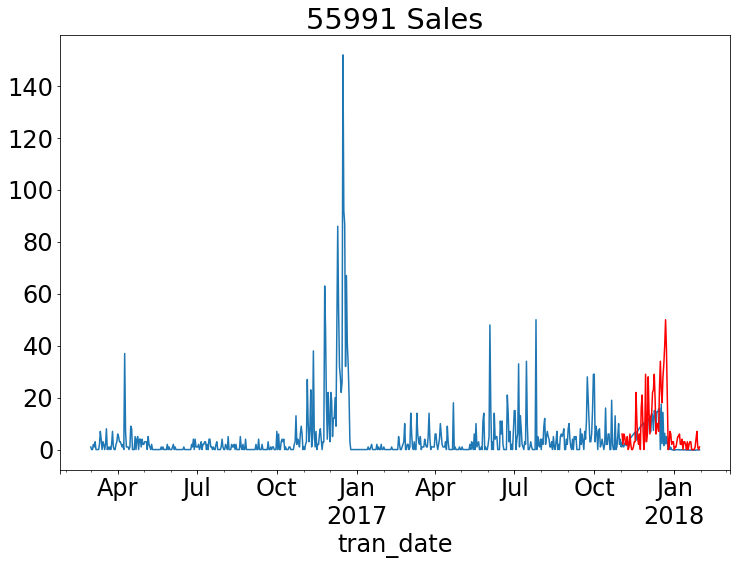

In [128]:
f, ax = plt.subplots(figsize=(12,8))

train['sales'].plot(ax=ax)
test['sales'].plot(ax=ax, color='r')
ax.set_title('55991 Sales')
#ax.set_xlim(right=pd.datetime(2018,1,1))
#ax.set_ylim(bottom=-5, top=50)
f.savefig('90day_pred_vanilla_correct_zeros.png')

In [129]:
predicted

[2.803713321685791,
 1.0519388914108276,
 1.0919532775878906,
 2.238210439682007,
 2.650108575820923,
 1.4795747995376587,
 3.2162222862243652,
 1.7951457500457764,
 1.9931458234786987,
 4.125058650970459,
 4.5476908683776855,
 5.006228446960449,
 5.466835021972656,
 5.868432998657227,
 6.328786849975586,
 6.693602561950684,
 3.5163075923919678,
 7.046271800994873,
 7.100050926208496,
 7.823749542236328,
 8.281742095947266,
 8.671671867370605,
 9.15095329284668,
 9.517827033996582,
 10.037110328674316,
 10.316307067871094,
 5.394006729125977,
 10.623010635375977,
 10.645723342895508,
 5.69756555557251,
 11.712259292602539,
 11.549898147583008,
 12.939995765686035,
 6.7526445388793945,
 13.944443702697754,
 13.032452583312988,
 7.360908508300781,
 14.962725639343262,
 14.04311752319336,
 8.234556198120117,
 14.57218074798584,
 14.578315734863281,
 15.412336349487305,
 15.873698234558105,
 0,
 17.498371124267578,
 2.2834227085113525,
 14.306666374206543,
 1.5023090839385986,
 6.247596263

In [136]:
metrics.mean_squared_error(test['sales'].values, predicted)

114.05062125803077

In [137]:
sum(test['sales'].values)

770

In [138]:
sum(predicted)

394.83341474831104

One of the first things that we saw in this model it the model going rogue. I.e., it just goes off fully negative or fully positive. 
What if we combine some sort of simulation into the model, which can pick lets say a zero for the predicted value with the same probability as its ocurrance in the dataset? This will bring the model back to the values most common in the dataset. 
This could be combined with a general Monte Carlo approach, in which every prediction can be updated to a monte carlo version, or similar.

Other features maybe to add which could account for the going rogue, adding a rolling min and rolling max for a number of time periods.

In [250]:
plot_df = pd.DataFrame(train).join(test, lsuffix='train', rsuffix='test')

In [251]:
plot_df.head()

,sku_keytrain,salestrain,selling_pricetrain,avg_discounttrain,store_region_ECtrain,store_region_FStrain,store_region_GTNtrain,store_region_KWAtrain,store_region_MPUtrain,store_region_NAtrain,...,agg4test,agg5test,agg6test,agg7test,agg8test,agg9test,agg10test,agg11test,nulstest,notnulstest
index,,,,,,,,,,,,,,,,,,,,,
2017-03-23,48676.0,2.0,5.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-24,48676.0,3.0,5.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-25,48676.0,11.0,5.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-26,48676.0,6.0,5.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-27,48676.0,8.0,5.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [252]:
plot_df = plot_df[['salestrain', 'salestest']]
plot_df.columns = ['pred', 'true']

In [254]:
threshold = (1-plot_df['true'].value_counts()[0]/len(plot_df))
print('Parameterization threshold is {}'.format(threshold))

Parameterization threshold is 0.9490445859872612


In [255]:
plot_df['pred'] = plot_df['pred'].apply(parameterize_output, args=[threshold])
pred = plot_df['pred'].apply(parameterize_output, args=[threshold]).values

In [256]:
plot_df.reset_index(inplace=True)
plot_df['index'] = pd.to_datetime(plot_df['index'])
plot_df.set_index('index', inplace=True)

In [257]:
plot_df.head()

,pred,true
index,,
2017-03-23,2.0,NaN
2017-03-24,3.0,NaN
2017-03-25,11.0,NaN
2017-03-26,6.0,NaN
2017-03-27,8.0,NaN


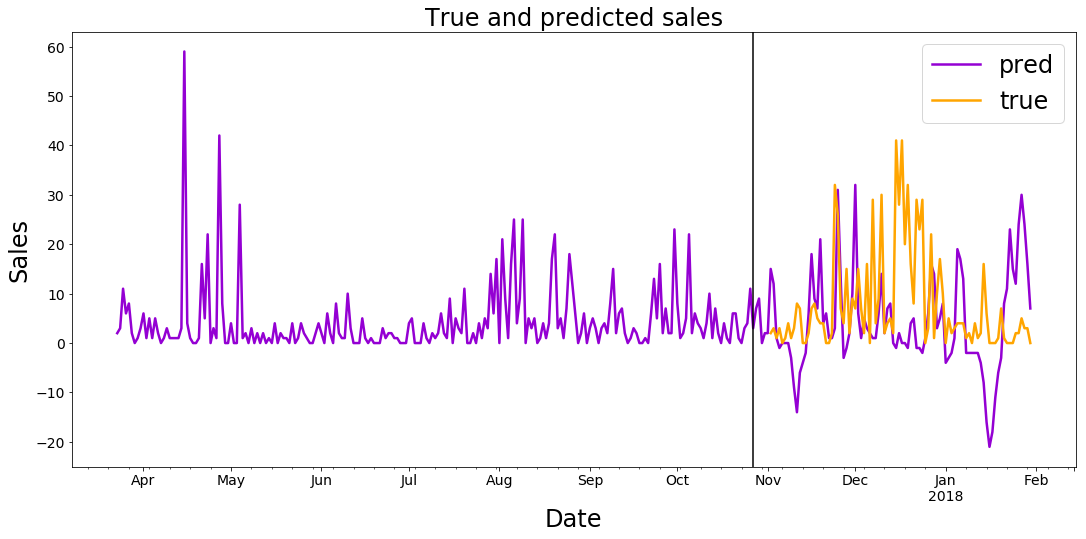

In [258]:
f, ax = plt.subplots(figsize=(18,8),)
plot_df.plot(ax=ax, color=['darkviolet', 'orange'], linewidth=2.5)
ax.set_title('True and predicted sales', fontdict=font)
ax.set_xlabel('Date', fontdict=font)
ax.set_ylabel('Sales', fontdict=font)

ax.axvline('2017-10-27', color='black')
plt.tick_params(labelsize=14)

plt.show()
f.savefig('55991_unsmoothed_new_14days.png')

In [259]:
plot_df.index[-90].date()

datetime.date(2017, 11, 2)

In [260]:
test_df = plot_df[plot_df.index.date >= plot_df.index[-90].date()]

In [261]:
rmse = np.sqrt(metrics.mean_squared_error(test_df.iloc[:,1], test_df.iloc[:,0]))
mse = metrics.mean_squared_error(test_df.iloc[:,1], test_df.iloc[:,0])
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)

RMSE: 14.522
MSE: 210.900


In [262]:
test_df.iloc[:,0].sum()

377.0

In [263]:
rmse = np.sqrt(metrics.mean_squared_error(test_df.iloc[1:,1], test_df.iloc[:-1,1]))
mse = metrics.mean_squared_error(test_df.iloc[1:,1], test_df.iloc[:-1,1])
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)

RMSE: 11.055
MSE: 122.202


In [264]:
test_df.iloc[:,1].sum()

700.0